# Semi-Supevised Learning

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Numpy arrays are used to store training and test data.
import numpy as np

# Pandas is used to manipulate tabular data.
import pandas as pd

#Seaborn is used for plotting relevant representations of the data we're handling
import seaborn as sns

# Matplotlib is used to plot graphs.
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
# Style options for plots.
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998).
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
welddb_ssl = pd.read_csv('welddb/welddb_yuxian.csv')

In [3]:
welddb_ssl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Carbon concentration (weight%)             1652 non-null   float64
 1   Silicon concentration (weight%)            1652 non-null   float64
 2   Manganese concentration (weight%)          1652 non-null   float64
 3   Sulphur concentration (weight%)            1652 non-null   float64
 4   Phosphorus concentration (weight%)         1652 non-null   float64
 5   Nickel concentration (weight%)             1652 non-null   float64
 6   Chromium concentration (weight%)           1652 non-null   float64
 7   Molybdenum concentration (weight%)         1652 non-null   float64
 8   Vanadium concentration (weight%)           1652 non-null   float64
 9   Copper concentration (weight%)             1652 non-null   float64
 10  Cobalt concentration (we

In [4]:
welddb_ssl.shape

(1652, 44)

In [5]:
# Drop the targets more suitable for supervised learning
columns_to_drop = welddb_ssl.columns[30:36]

welddb_ssl = welddb_ssl.drop(columns=columns_to_drop)

In [8]:
# Drop the 'Current (A)' and 'Voltage (V)' columns
welddb_ssl = welddb_ssl.drop(columns=welddb_ssl.columns[[21, 22]])

In [9]:
welddb_ssl.shape

(1652, 36)

In [10]:
welddb_ssl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 36 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Carbon concentration (weight%)             1652 non-null   float64
 1   Silicon concentration (weight%)            1652 non-null   float64
 2   Manganese concentration (weight%)          1652 non-null   float64
 3   Sulphur concentration (weight%)            1652 non-null   float64
 4   Phosphorus concentration (weight%)         1652 non-null   float64
 5   Nickel concentration (weight%)             1652 non-null   float64
 6   Chromium concentration (weight%)           1652 non-null   float64
 7   Molybdenum concentration (weight%)         1652 non-null   float64
 8   Vanadium concentration (weight%)           1652 non-null   float64
 9   Copper concentration (weight%)             1652 non-null   float64
 10  Cobalt concentration (we

## Hardness Prediction

In [11]:
def select_target(df, target_column, target_columns):
    """
    Function to temporarily keep only the selected target column and features.
    
    Parameters:
    df (pd.DataFrame): The dataframe to modify.
    target_column (str): The target column to keep.
    target_columns (list): List of all potential target columns.
    
    Returns:
    pd.DataFrame: A new dataframe with the selected target and other columns intact.
    """
    columns_to_exclude = [col for col in target_columns if col != target_column]
    
    return df.drop(columns=columns_to_exclude)

target_columns = [
    'Hardness (kgmm-2)', '50 % FATT', 'Primary ferrite in microstructure (%)',
    'Ferrite with second phase (%)', 'Acicular ferrite (%)',
    'Martensite (%)', 'Ferrite with carbide aggregate (%)'
]

target_column = 'Hardness (kgmm-2)'
welddb_ssl_selected = select_target(welddb_ssl, target_column, target_columns)


In [13]:
welddb_ssl_selected.shape

(1652, 30)

In [14]:
welddb_ssl_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 30 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Carbon concentration (weight%)             1652 non-null   float64
 1   Silicon concentration (weight%)            1652 non-null   float64
 2   Manganese concentration (weight%)          1652 non-null   float64
 3   Sulphur concentration (weight%)            1652 non-null   float64
 4   Phosphorus concentration (weight%)         1652 non-null   float64
 5   Nickel concentration (weight%)             1652 non-null   float64
 6   Chromium concentration (weight%)           1652 non-null   float64
 7   Molybdenum concentration (weight%)         1652 non-null   float64
 8   Vanadium concentration (weight%)           1652 non-null   float64
 9   Copper concentration (weight%)             1652 non-null   float64
 10  Cobalt concentration (we

### Remove the instances with missing values

In [18]:
def drop_missing_except_target(df, target_column):
    """
    Drops instances with missing values in all columns except the target column.
    
    Parameters:
    df (pd.DataFrame): The dataframe to clean.
    target_column (str): The target column to exclude from the NaN drop process.
    
    Returns:
    pd.DataFrame: A new dataframe with rows dropped where NaN values exist, except in the target column.
    """
    columns_except_target = df.columns[df.columns != target_column]
    df_cleaned = df.dropna(subset=columns_except_target)
    
    return df_cleaned

welddb_ssl_cleaned = drop_missing_except_target(welddb_ssl_selected, target_column)

In [20]:
welddb_ssl_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1307 entries, 0 to 1436
Data columns (total 30 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Carbon concentration (weight%)             1307 non-null   float64
 1   Silicon concentration (weight%)            1307 non-null   float64
 2   Manganese concentration (weight%)          1307 non-null   float64
 3   Sulphur concentration (weight%)            1307 non-null   float64
 4   Phosphorus concentration (weight%)         1307 non-null   float64
 5   Nickel concentration (weight%)             1307 non-null   float64
 6   Chromium concentration (weight%)           1307 non-null   float64
 7   Molybdenum concentration (weight%)         1307 non-null   float64
 8   Vanadium concentration (weight%)           1307 non-null   float64
 9   Copper concentration (weight%)             1307 non-null   float64
 10  Cobalt concentration (weight%

### Get dummy variables for the categorical features

In [21]:
import pandas as pd

def dummy_variables(df, target_column, categorical_columns):
    """
    Prepares the feature matrix X and target vector y from a dataframe by creating dummy variables.
    
    Parameters:
    df (pd.DataFrame): The input dataframe.
    target_column (str): The name of the target column.
    categorical_columns (list): List of categorical columns to convert to dummy variables.
    
    Returns:
    X (pd.DataFrame): The feature matrix with dummy variables.
    y (pd.Series): The target variable.
    """
    dummies = pd.get_dummies(df[categorical_columns], drop_first=True)

    y = df[target_column]

    X_ = df.drop(categorical_columns + [target_column], axis=1).astype('float64')
    X = pd.concat([X_, dummies], axis=1)
    
    return X, y

categorical_columns = ['AC or DC', 'Electrode positive or negative', 'Type of weld']

X, y = dummy_variables(welddb_ssl_cleaned, target_column, categorical_columns)


In [26]:
X.shape

(1307, 36)

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1307 entries, 0 to 1436
Data columns (total 36 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Carbon concentration (weight%)             1307 non-null   float64
 1   Silicon concentration (weight%)            1307 non-null   float64
 2   Manganese concentration (weight%)          1307 non-null   float64
 3   Sulphur concentration (weight%)            1307 non-null   float64
 4   Phosphorus concentration (weight%)         1307 non-null   float64
 5   Nickel concentration (weight%)             1307 non-null   float64
 6   Chromium concentration (weight%)           1307 non-null   float64
 7   Molybdenum concentration (weight%)         1307 non-null   float64
 8   Vanadium concentration (weight%)           1307 non-null   float64
 9   Copper concentration (weight%)             1307 non-null   float64
 10  Cobalt concentration (weight%

In [27]:
y.shape

(1307,)

In [29]:
X.describe()

,Carbon concentration (weight%),Silicon concentration (weight%),Manganese concentration (weight%),Sulphur concentration (weight%),Phosphorus concentration (weight%),Nickel concentration (weight%),Chromium concentration (weight%),Molybdenum concentration (weight%),Vanadium concentration (weight%),Copper concentration (weight%),...,Boron concentration (ppm),Niobium concentration (ppm),Tin concentration (ppm),Arsenic concentration (ppm),Antimony concentration (ppm),Heat input (kJmm-1),Interpass temperature (°C),Post weld heat treatment temperature (°C),Post weld heat treatment time (hours),Power (W)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,...,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,0.075487,0.326794,1.239870,0.009519,0.012955,0.150835,1.089995,0.233191,0.032459,0.042122,...,2.441469,71.725325,5.816077,3.599438,4.070834,1.672196,203.247896,304.530987,4.172533,8838.534047
std,0.024983,0.099858,0.371322,0.012380,0.021541,0.501723,2.489040,0.414760,0.074261,0.144100,...,7.076278,182.602717,20.296603,15.358592,15.705482,1.339382,39.899641,302.878052,5.751537,11159.594592
min,0.030000,0.040000,0.270000,0.001000,0.002000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,0.000000,0.000000,2645.000000
25%,0.060000,0.280000,0.990000,0.006000,0.007000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,200.000000,0.000000,0.000000,3570.000000
50%,0.074000,0.330000,1.310000,0.007000,0.010000,0.000000,0.000000,0.000000,0.000300,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,200.000000,250.000000,2.000000,3570.000000
75%,0.088000,0.370000,1.440000,0.010000,0.014000,0.030000,0.500000,0.270000,0.010000,0.000000,...,5.000000,5.000000,0.000000,0.000000,0.000000,1.800000,200.000000,580.000000,8.000000,8261.250000
max,0.160000,0.700000,2.250000,0.140000,0.250000,3.500000,9.500000,1.500000,0.320000,1.400000,...,69.000000,985.000000,200.000000,200.000000,200.000000,7.900000,300.000000,760.000000,24.000000,47100.000000


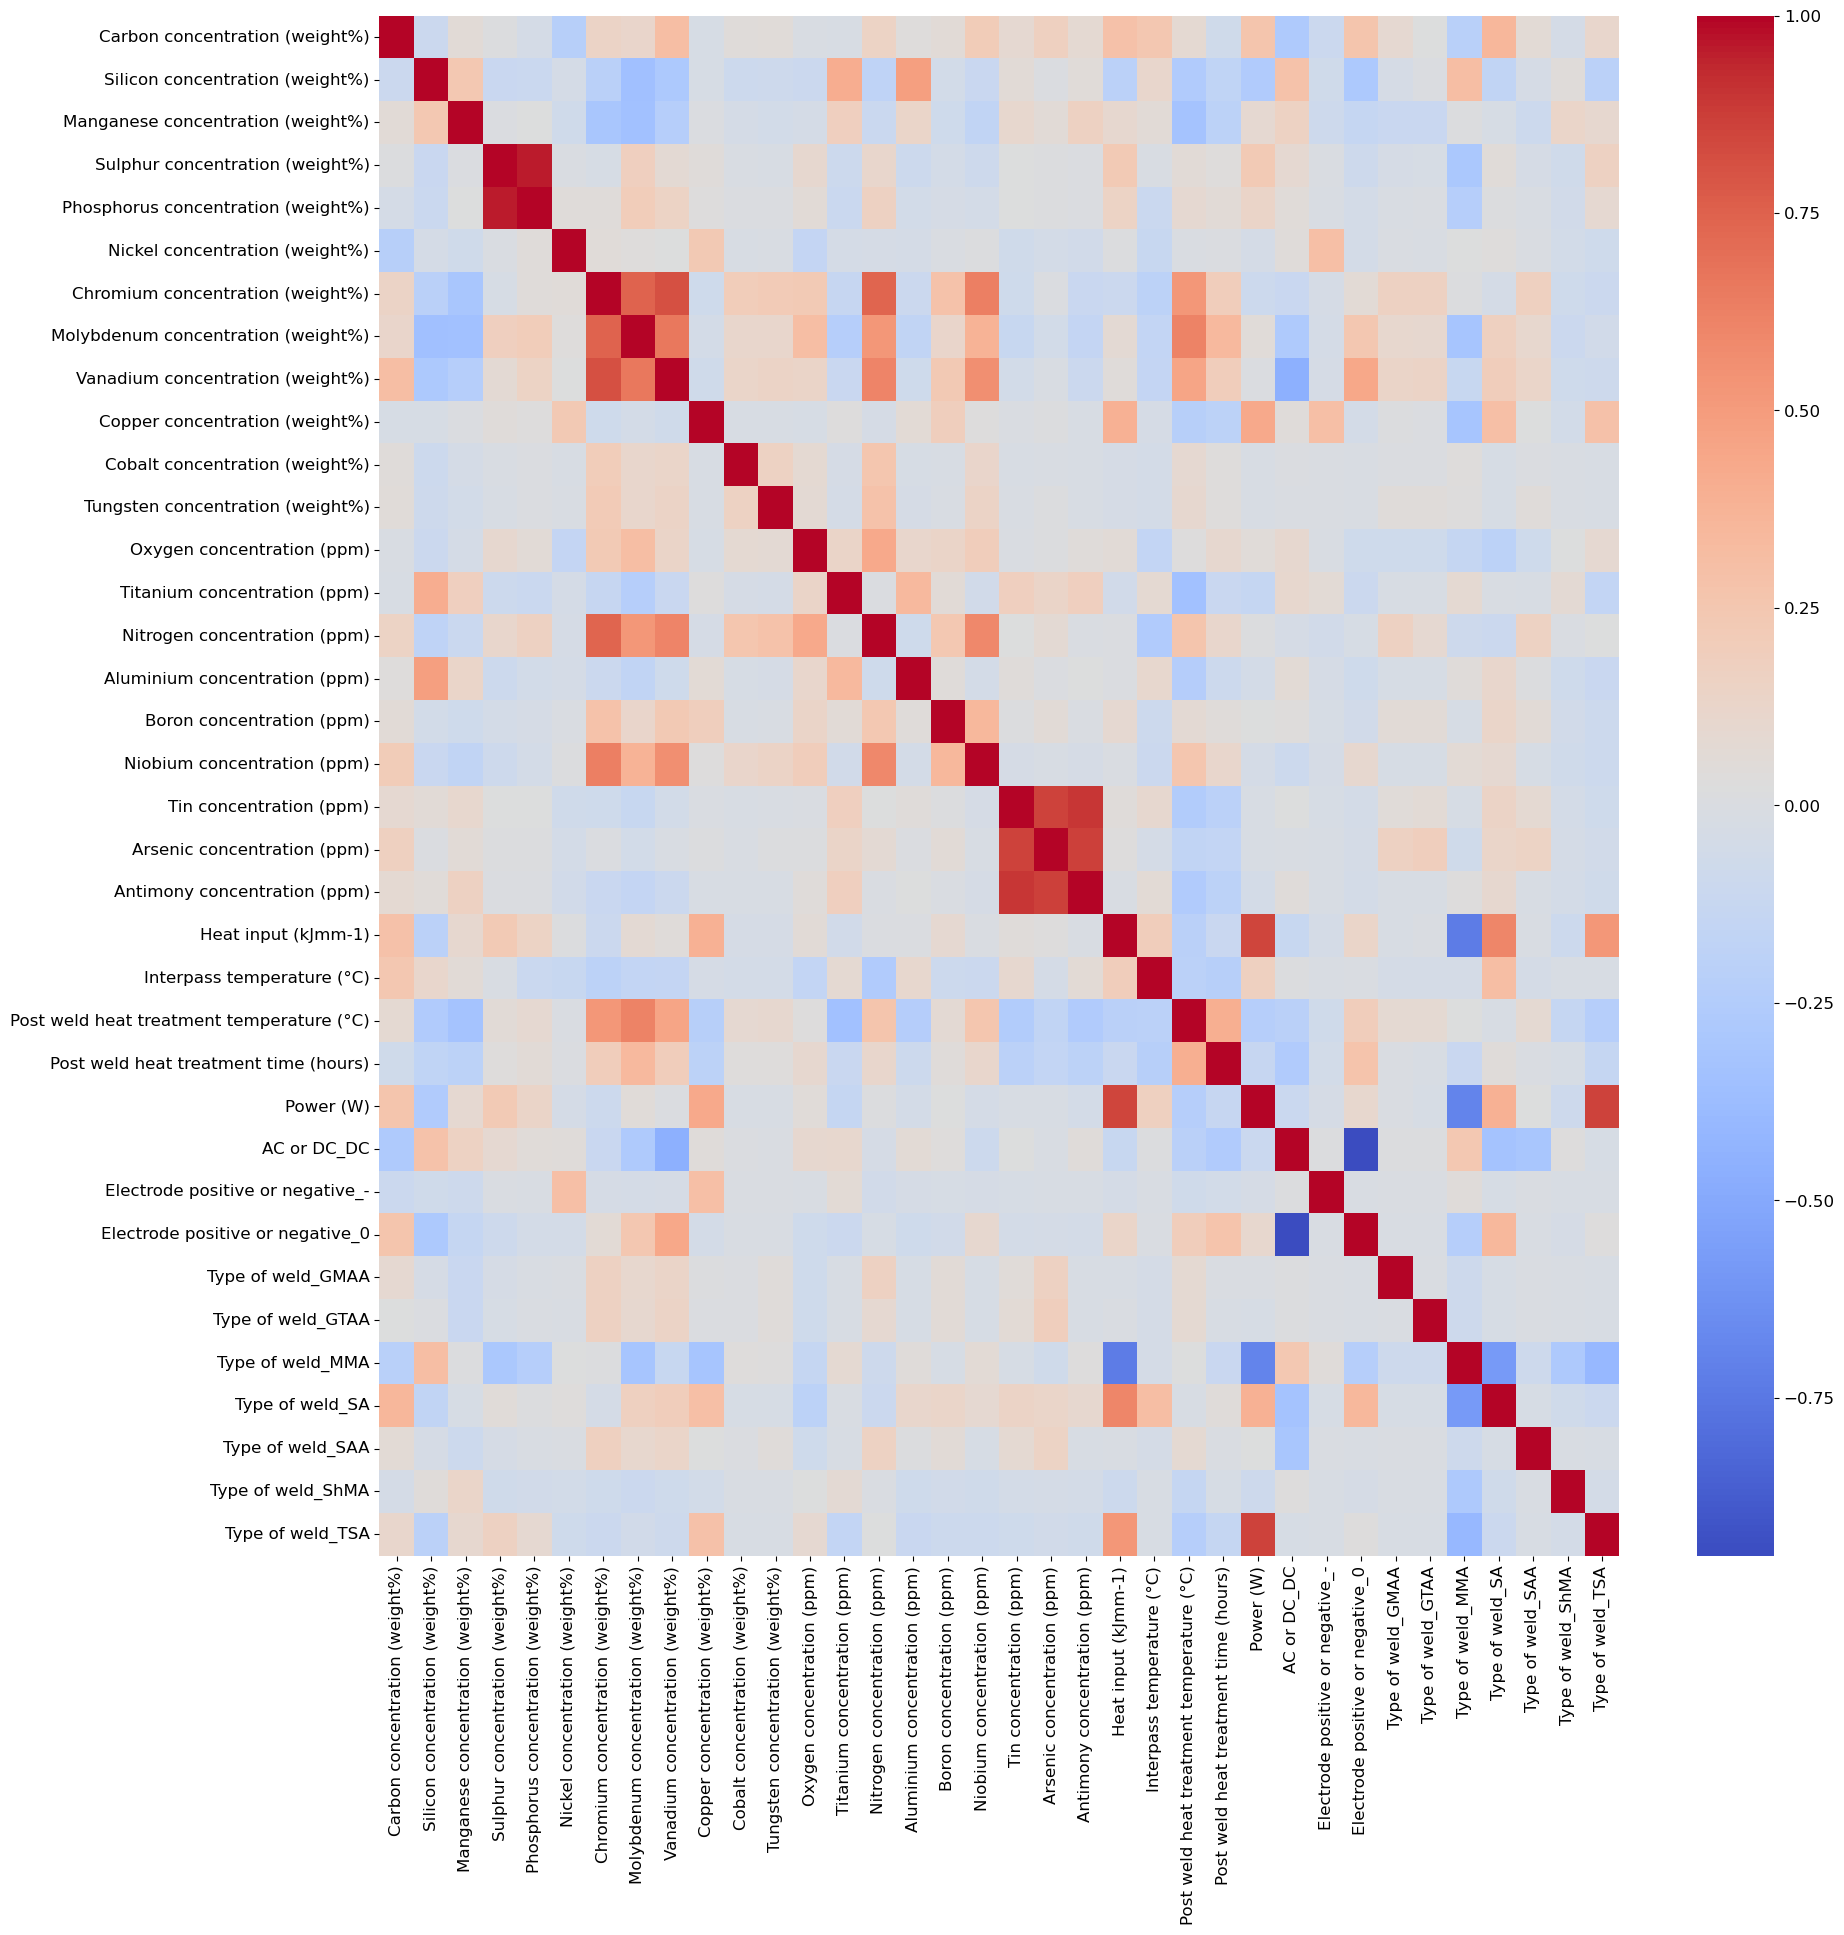

In [36]:
# Plotting the correlation heatmap for X
f, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(X.corr(), 
                 xticklabels=X.columns,
                 yticklabels=X.columns,
                 cmap='coolwarm')

plt.show()

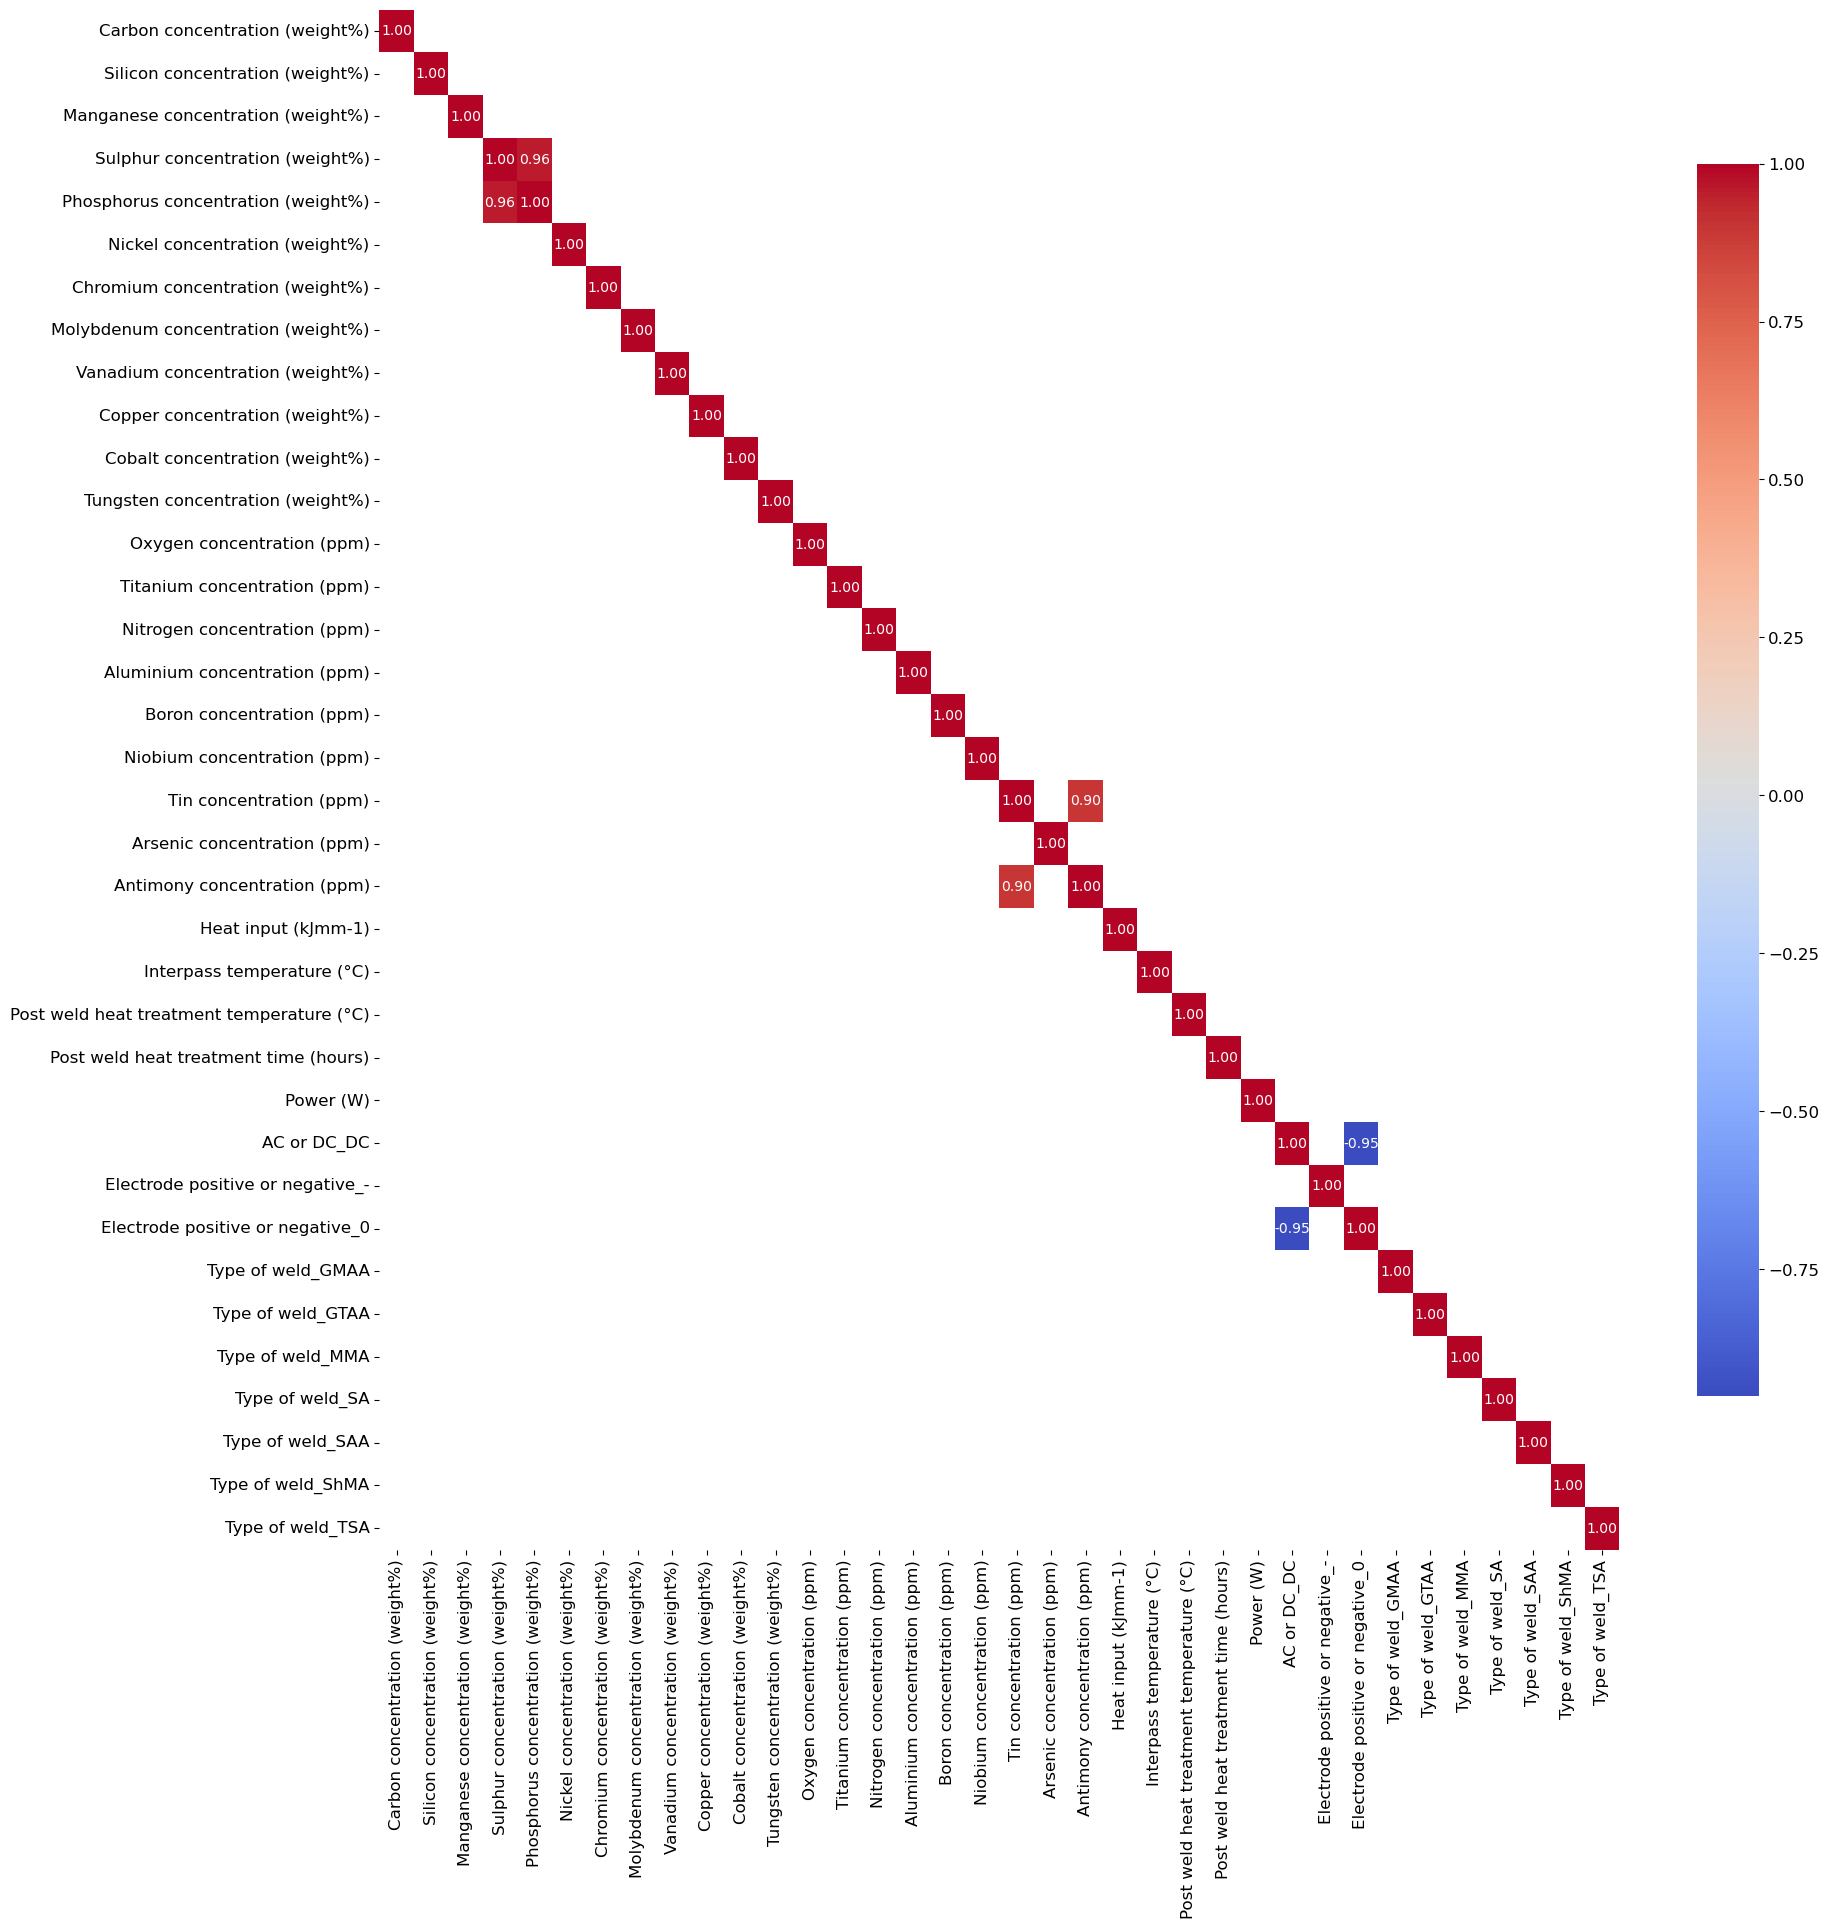

In [37]:
# Create the correlation matrix
corr_matrix = X.corr()

# Apply a mask to only show values with an absolute correlation higher than 0.9
mask = np.abs(corr_matrix) < 0.9

f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr_matrix, 
            mask=mask,  # Mask values below the threshold
            xticklabels=X.columns,
            yticklabels=X.columns,
            cmap='coolwarm',  # Optional: choose a color palette
            annot=True,       # Show the correlation values in the cells
            fmt=".2f",        # Format the annotation to 2 decimal places
            cbar_kws={"shrink": .8})  # Optional: adjust colorbar size

plt.show()

In [48]:
# Check the proportion of zero values in the features
non_bool_columns = X.select_dtypes(exclude=['bool']).columns

zero_values = (X[non_bool_columns] == 0).sum() / X[non_bool_columns].shape[0]
print(zero_values[zero_values > 0])

Nickel concentration (weight%)               0.721500
Chromium concentration (weight%)             0.648814
Molybdenum concentration (weight%)           0.635042
Vanadium concentration (weight%)             0.498087
Copper concentration (weight%)               0.772762
Cobalt concentration (weight%)               0.945677
Tungsten concentration (weight%)             0.986228
Oxygen concentration (ppm)                   0.237950
Titanium concentration (ppm)                 0.451415
Nitrogen concentration (ppm)                 0.260138
Aluminium concentration (ppm)                0.526396
Boron concentration (ppm)                    0.733741
Niobium concentration (ppm)                  0.634277
Tin concentration (ppm)                      0.830145
Arsenic concentration (ppm)                  0.839327
Antimony concentration (ppm)                 0.848508
Post weld heat treatment temperature (°C)    0.439174
Post weld heat treatment time (hours)        0.439174
dtype: float64


In [47]:
# Calculate correlation with the target
correlation_with_target = X[['Sulphur concentration (weight%)', 'Phosphorus concentration (weight%)']].corrwith(y)
print(correlation_with_target)

Sulphur concentration (weight%)      -0.411487
Phosphorus concentration (weight%)   -0.370026
dtype: float64


In [49]:
X = X.drop(['Antimony concentration (ppm)', 'Phosphorus concentration (weight%)'], axis=1)

In [50]:
X.shape

(1307, 34)

### Self-training

In [ ]:
# bool_columns = [
#     'AC or DC_DC', 
#     'Electrode positive or negative_-', 
#     'Electrode positive or negative_0', 
#     'Type of weld_GMAA', 
#     'Type of weld_GTAA', 
#     'Type of weld_MMA', 
#     'Type of weld_SA', 
#     'Type of weld_SAA', 
#     'Type of weld_ShMA', 
#     'Type of weld_TSA'
# ]

# # Convert the boolean columns to integers
# X[bool_columns] = X[bool_columns].astype(int)
